# Test: Gas Evolution

In this chapter we are comparing the gas evolution to the analytical solution.

## Analytical Solution

Viscous gas accretion has analytical solutions as given by [Lynden-Bell & Pringle (1974)](https://doi.org/10.1093/mnras/168.3.603) or [Hartmann et al. (1998)](https://doi.org/10.1086/305277).

We assume a viscously evolving disk

$\frac{\partial}{\partial t} \Sigma_\mathrm{g} = \frac{3}{r}\frac{\partial}{\partial r} \left[ \sqrt{r} \frac{\partial}{\partial r} \left( \sqrt{r} \nu \Sigma_\mathrm{g} \right) \right]$

with an $\alpha$-viscosity prescription given by

$\begin{split}
\nu &= \alpha \frac{c_\mathrm{s}^2}{\Omega_\mathrm{K}}\\
&\propto r^{s} \cdot r^{q} \cdot r^{\frac{3}{2}} = r^\gamma.
\end{split}$

In the default simulation we have $s=0$, $q=-\frac{1}{2}$, and therefore $\gamma=1$.

This differential equation for viscous accretion has self-similar solutions given by

$\Sigma_\mathrm{g} = \frac{C}{3\pi\nu_1R^\gamma}T^{-\frac{5/2-\gamma}{2-\gamma}} \exp \left[ -\frac{R^{2-\gamma}}{T} \right]$

with a dimensionless scaling of the grid $R=\frac{r}{r_1}$, the radial scaling factor $r_1$ and the viscosity at the scaling location $\nu_1=\nu\left(r_1\right)$.

$T=\frac{t}{t_\mathrm{s}}+1$ is the dimensionless time and

$t_\mathrm{s} = \frac{1}{3 \left( 2-\gamma \right)^2}\frac{r_1^2}{\nu_1}$.

$C$ is a scaling constant that defines the initial mass of the disk $M_0$

$C = M_0 \frac{3\nu_1}{2r_1^2\left(2-\gamma\right)}$.

We can now write a function that returns the surface density profile at any given time to compare it against the simulation result.

In [1]:
def LBP74_analytical(r, rc, nu, M0, t):
    """Function calculates the self-similar solution of Lynden-Bell & Pringle (1974)
    It is assuming that the viscosity follows a power law.
    
    Parameters
    ----------
    r : Field
        Radial grid
    rc : float
        Initial critical cutoff radius
    nu : Field
        Kinematic viscosity
    M0 : float
        Initial disk mass
    t : float
        Time
        
    Returns
    -------
    Sigma : Field
        Gas surface density profile at time t
    """
    import numpy as np
    
    # Get power law index of viscosity
    gamma = np.mean( np.diff( np.log10(nu) ) / np.diff( np.log10(r) ) )
    
    # Convert to dimensionless quantities
    R = r/rc
    nu1 = nu[0] * (rc/r[0])**gamma
    ts = rc**2 / (3*nu1*(2-gamma)**2)
    T = t/ts + 1
    
    # Calculate scaling constant
    C = (2-gamma)*M0 * 3*nu1/(2*rc**2)
    
    return C / (3*np.pi*nu1*R**gamma) * T**(-(5/2-gamma)/(2-gamma)) * np.exp(-R**(2-gamma)/T)

We test the gas evolution for the default model.

In [2]:
from dustpy import Simulation
sim = Simulation()
sim.initialize()

In [3]:
import matplotlib.pyplot as plt

We want to compare the simulation to the analytical solution at four discrete snapshots between $10,000$ and $10,000,000$ years.

In [4]:
import dustpy.constants as c
import numpy as np
snapshots = np.logspace(4., 7, num=4, base=10.) * c.year

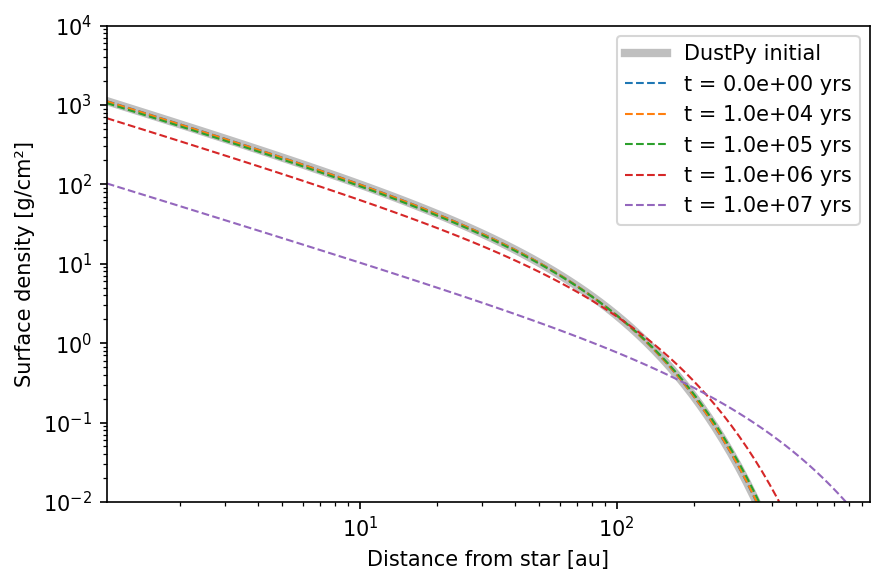

In [5]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.loglog(sim.grid.r/c.au, sim.gas.Sigma, c="black", lw=4, alpha=0.25, label="DustPy initial")
ax.loglog(sim.grid.r/c.au, LBP74_analytical(sim.grid.r, sim.ini.gas.SigmaRc, sim.gas.nu, sim.ini.gas.Mdisk, 0), "--", lw=1, c="C0", label="t = 0.0e+00 yrs")
for i in range(0, len(snapshots)):
    cstr = "C" + str(i+1)
    ax.loglog(sim.grid.r/c.au, LBP74_analytical(sim.grid.r, sim.ini.gas.SigmaRc, sim.gas.nu, sim.ini.gas.Mdisk, snapshots[i]), "--", lw=1, c=cstr, label="t = {:3.1e} yrs".format(snapshots[i]/c.year))
ax.legend()
ax.set_xlim(sim.grid.r[0]/c.au, sim.grid.r[-1]/c.au)
ax.set_ylim(1.e-2, 1.e4)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel("Surface density [g/cm²]")
fig.tight_layout()

## Setting up DustPy

We now set up a `DustPy` simulation to compare the gas evolution to the analytical solutions.

### Turning off Dust Evolution

Since we're not interested in the dust evolution and since this is the computationally most expensive part of `DustPy`, we simply turn it off. We do this by setting all dust source terms to zero and by unsetting their updaters.

In [6]:
sim.dust.S.coag[...] = 0.
sim.dust.S.coag.updater = None
sim.dust.S.ext[...] = 0.
sim.dust.S.ext.updater = None
sim.dust.S.hyd[...] = 0.
sim.dust.S.hyd.updater = None
sim.dust.S.tot[...] = 0.
sim.dust.S.tot.updater = None
sim.dust.S.updater = None
sim.update()

In addition to that we remove the integration instruction of the dust from the instructions set.

In [7]:
sim.integrator.instructions

[Instruction (Dust: explicit 5th-order adaptive Cash-Karp method),
 Instruction (Gas: implicit 1st-order Euler method)]

In [8]:
del(sim.integrator.instructions[0])

In [9]:
sim.integrator.instructions

[Instruction (Gas: implicit 1st-order Euler method)]

### Modifying Integration Variable

The default simulation will take the time step of the adaptive dust integration scheme for the implicit gas evolution. This is usually small enough, since dust evolution requires rather small time steps.

Without dust sources, however, this step size will become large, and we have to set a stepsize function for the integration variable, which we calculate from the gas sources and by using a safety factor of $0.01$.

In [10]:
def dt(sim):
    return 0.01 * np.max( np.abs( sim.gas.Sigma[:] / sim.gas.S.tot[:] ) )

In [11]:
sim.t.updater = dt

Furthermore, we have to set the desired snapshots, that we already defined above.

In [12]:
sim.t.snapshots = snapshots

### Setting Writer Options

We also change the name of the output directory and allow `DustPy` to overwrite existing data files.

In [13]:
sim.writer.datadir = "8_data"
sim.writer.overwrite = True

We can now run the simulation.

In [14]:
sim.run()


DustPy v0.1.0

Documentation: https://dustpy.rtfd.io
PyPI:          https://pypi.org/project/dustpy
GitHub:        https://github.com/stammler/dustpy

Please cite:   Stammler & Birnstiel (in prep.)

Checking for mass conservation...

    - Sticking:
        max. rel. error:  2.81e-14
        for particle collision
            m[114] =  1.93e+04 g    with
            m[116] =  3.73e+04 g
    - Full fragmentation:
        max. rel. error:  3.33e-16
        for particle collision
            m[4] =  3.73e-12 g    with
            m[6] =  7.20e-12 g
    - Cratering:
        max. rel. error:  1.78e-15
        for particle collision
            m[110] =  5.18e+03 g    with
            m[118] =  7.20e+04 g

Creating data directory '8_data'.
Writing file 8_data/data0000.hdf5
Writing dump file 8_data/frame.dmp
Writing file 8_data/data0001.hdf5
Writing dump file 8_data/frame.dmp
Writing file 8_data/data0002.hdf5
Writing dump file 8_data/frame.dmp
Writing file 8_data/data0003.hdf5
Writing dump f

### Reading and Plotting Data

We now read the data and compare it to the analytical solutions.

In [15]:
data = sim.writer.read.all()

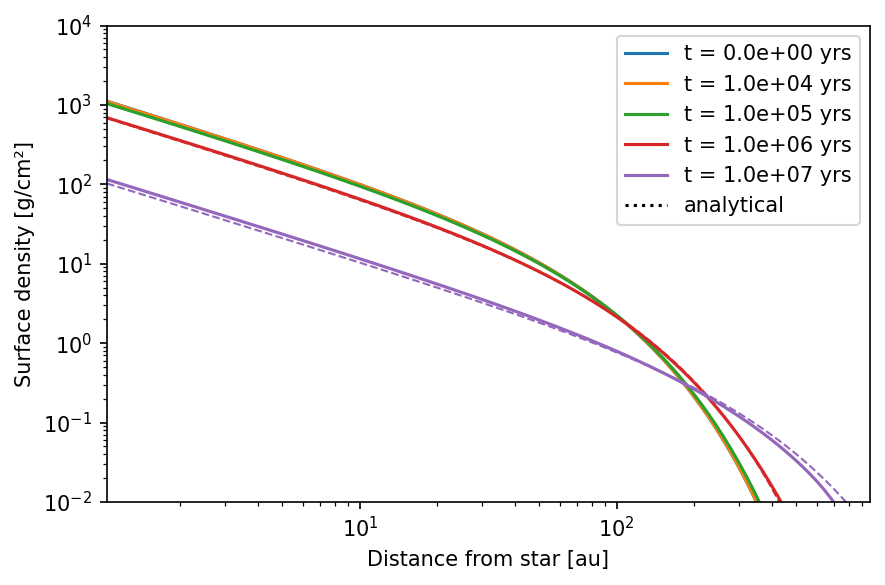

In [16]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.loglog(data.grid.r[0]/c.au, data.gas.Sigma[0], c="C0", label="t = 0.0e+00 yrs")
for i in range(1, len(sim.t.snapshots)+1):
    cstr = "C"+str(i)
    ax.loglog(sim.grid.r/c.au, LBP74_analytical(sim.grid.r, sim.ini.gas.SigmaRc, data.gas.nu[0], sim.ini.gas.Mdisk, data.t[i]), "--", lw=1, c=cstr)
    ax.loglog(data.grid.r[i]/c.au, data.gas.Sigma[i], c=cstr, label="t = {:3.1e} yrs".format(data.t[i]/c.year))
ax.plot(0., 0., ":", c="black", label="analytical")
ax.legend()
ax.set_xlim(sim.grid.r[0]/c.au, sim.grid.r[-1]/c.au)
ax.set_ylim(1.e-2, 1.e4)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel("Surface density [g/cm²]")
fig.tight_layout()

As you can see, the time evolution of the gas disk (in the default model) is in good agreement with the analytical solutions.

## Modifying the Power Law Index

We now run the same test again, but we change the initial power law index of the gas surface density profile from $-1.0$ to $-1.5$.

In [17]:
sim = Simulation()
sim.ini.gas.SigmaExp = -1.5
sim.initialize()

In [18]:
sim.dust.S.coag[...] = 0.
sim.dust.S.coag.updater = None
sim.dust.S.ext[...] = 0.
sim.dust.S.ext.updater = None
sim.dust.S.hyd[...] = 0.
sim.dust.S.hyd.updater = None
sim.dust.S.tot[...] = 0.
sim.dust.S.tot.updater = None
sim.dust.S.updater = None
sim.update()

In [19]:
del(sim.integrator.instructions[0])

In [20]:
sim.t.snapshots = snapshots
sim.t.updater = dt

In [21]:
sim.writer.datadir = "8_data"
sim.writer.overwrite = True

In [22]:
sim.run()


DustPy v0.1.0

Documentation: https://dustpy.rtfd.io
PyPI:          https://pypi.org/project/dustpy
GitHub:        https://github.com/stammler/dustpy

Please cite:   Stammler & Birnstiel (in prep.)

Checking for mass conservation...

    - Sticking:
        max. rel. error:  2.81e-14
        for particle collision
            m[114] =  1.93e+04 g    with
            m[116] =  3.73e+04 g
    - Full fragmentation:
        max. rel. error:  3.33e-16
        for particle collision
            m[4] =  3.73e-12 g    with
            m[6] =  7.20e-12 g
    - Cratering:
        max. rel. error:  1.78e-15
        for particle collision
            m[110] =  5.18e+03 g    with
            m[118] =  7.20e+04 g

Writing file 8_data/data0000.hdf5
Writing dump file 8_data/frame.dmp
Writing file 8_data/data0001.hdf5
Writing dump file 8_data/frame.dmp
Writing file 8_data/data0002.hdf5
Writing dump file 8_data/frame.dmp
Writing file 8_data/data0003.hdf5
Writing dump file 8_data/frame.dmp
Writing file 

In [23]:
data = sim.writer.read.all()

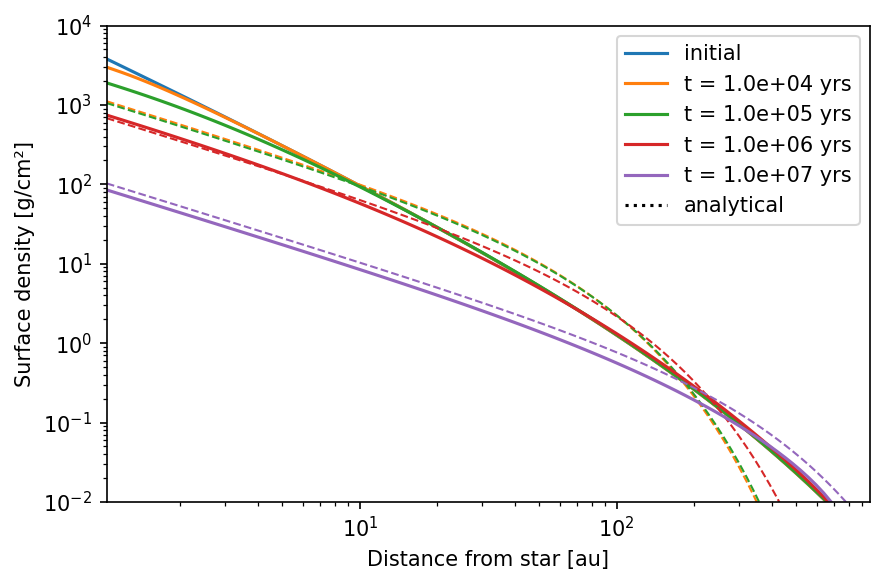

In [24]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.loglog(data.grid.r[0]/c.au, data.gas.Sigma[0], c="C0", label="initial")
for i in range(1, len(sim.t.snapshots)+1):
    cstr = "C"+str(i)
    ax.loglog(sim.grid.r/c.au, LBP74_analytical(sim.grid.r, sim.ini.gas.SigmaRc, data.gas.nu[0], sim.ini.gas.Mdisk, data.t[i]), "--", lw=1, c=cstr)
    ax.loglog(data.grid.r[i]/c.au, data.gas.Sigma[i], c=cstr, label="t = {:3.1e} yrs".format(data.t[i]/c.year))
ax.plot(0., 0., ":", c="black", label="analytical")
ax.legend()
ax.set_xlim(sim.grid.r[0]/c.au, sim.grid.r[-1]/c.au)
ax.set_ylim(1.e-2, 1.e4)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel("Surface density [g/cm²]")
fig.tight_layout()

The final snapshot looks fine, the previous ones, however, are quite a bit off. Even the initial surface density does not match the analytic solution.  
What went wrong?

The problem is that the initial surface density is not in steady state and therefore not a self-similar solution.  
In steady state the mass flux is constant

$\frac{\partial}{\partial r} \left( 3\pi\Sigma_\mathrm{g}\nu \right) = \text{const.}$

Or in other words

$\Sigma_\mathrm{g}\nu \propto r^p r^\gamma = r^0 \\ \Rightarrow p+\gamma = 0$

We've change $p$ from $-1$ to $-1.5$, but we have not changed $\gamma$, which is still $1$ from the default setup as described above. Therefore, in our initial conditions we have

$p+\gamma=-0.5 \neq 0$.

Over time the system finds a steady state. Since the temperature profile and the $\alpha$-viscosity parameter are both fix in the default model, the only way for the system to get into steady state is by changing the slope of the gas surface density. This is what happened here: the surface density profile went from $-1.5$ initially to $-1$ after $10\,$Myrs.

To fix this problem we need to change the viscosity of the setup. We can do this by either changing the temperature profile, or by changing the $\alpha$-profile. We are changing $\alpha$ here

$\alpha \left( r \right) \propto r^\frac{1}{2}$

which leads to $\gamma = 1.5$.

In [25]:
sim = Simulation()
sim.ini.gas.SigmaExp = -1.5
sim.initialize()

In [26]:
sim.gas.alpha[:] = sim.ini.gas.alpha * (sim.grid.r[:]/sim.ini.gas.SigmaRc)**0.5

In [27]:
sim.dust.S.coag[...] = 0.
sim.dust.S.coag.updater = None
sim.dust.S.ext[...] = 0.
sim.dust.S.ext.updater = None
sim.dust.S.hyd[...] = 0.
sim.dust.S.hyd.updater = None
sim.dust.S.tot[...] = 0.
sim.dust.S.tot.updater = None
sim.dust.S.updater = None
sim.update()

In [28]:
del(sim.integrator.instructions[0])

In [29]:
sim.t.snapshots = snapshots
sim.t.updater = dt

In [30]:
sim.writer.datadir = "8_data"
sim.writer.overwrite = True

In [31]:
sim.run()


DustPy v0.1.0

Documentation: https://dustpy.rtfd.io
PyPI:          https://pypi.org/project/dustpy
GitHub:        https://github.com/stammler/dustpy

Please cite:   Stammler & Birnstiel (in prep.)

Checking for mass conservation...

    - Sticking:
        max. rel. error:  2.81e-14
        for particle collision
            m[114] =  1.93e+04 g    with
            m[116] =  3.73e+04 g
    - Full fragmentation:
        max. rel. error:  3.33e-16
        for particle collision
            m[4] =  3.73e-12 g    with
            m[6] =  7.20e-12 g
    - Cratering:
        max. rel. error:  1.78e-15
        for particle collision
            m[110] =  5.18e+03 g    with
            m[118] =  7.20e+04 g

Writing file 8_data/data0000.hdf5
Writing dump file 8_data/frame.dmp
Writing file 8_data/data0001.hdf5
Writing dump file 8_data/frame.dmp
Writing file 8_data/data0002.hdf5
Writing dump file 8_data/frame.dmp
Writing file 8_data/data0003.hdf5
Writing dump file 8_data/frame.dmp
Writing file 

In [32]:
data = sim.writer.read.all()

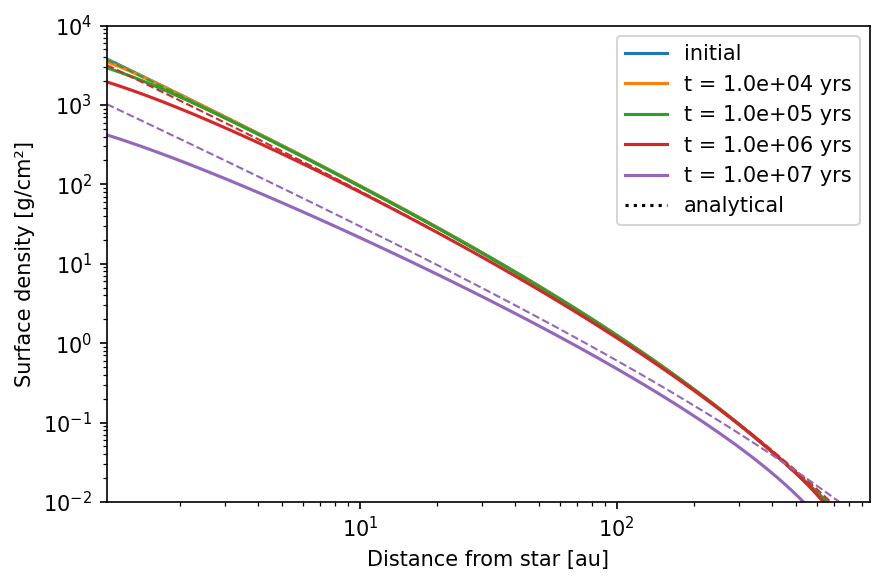

In [33]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.loglog(data.grid.r[0]/c.au, data.gas.Sigma[0], c="C0", label="initial")
for i in range(1, len(sim.t.snapshots)+1):
    cstr = "C"+str(i)
    ax.loglog(sim.grid.r/c.au, LBP74_analytical(sim.grid.r, sim.ini.gas.SigmaRc, data.gas.nu[0], sim.ini.gas.Mdisk, data.t[i]), "--", lw=1, c=cstr)
    ax.loglog(data.grid.r[i]/c.au, data.gas.Sigma[i], c=cstr, label="t = {:3.1e} yrs".format(data.t[i]/c.year))
ax.plot(0., 0., ":", c="black", label="analytical")
ax.legend()
ax.set_xlim(sim.grid.r[0]/c.au, sim.grid.r[-1]/c.au)
ax.set_ylim(1.e-2, 1.e4)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel("Surface density [g/cm²]")
fig.tight_layout()

This is closer to the analytical solutions. However, there are stil deviations at the inner boundary of the grid.

The reason for this is the inner boundary condition.  
By default this is set to constant gradient

$\frac{1}{r}\frac{\partial}{\partial r} \left( r\Sigma_\mathrm{g} \right) = \text{const.}$

This can be set exactly within a linear system, such as the one that is solved for gas evolution. A surface density profile of $-1$ as is set for the default model has automatically a constant gradient at the inner boundary. But a surface density profile of $-1.5$ does not. Here we need to change the inner boundary condition to constant power law.

In [34]:
sim = Simulation()
sim.ini.gas.SigmaExp = -1.5
sim.initialize()

In [35]:
sim.gas.alpha[:] = sim.ini.gas.alpha * (sim.grid.r[:]/sim.ini.gas.SigmaRc)**0.5

In [36]:
sim.dust.S.coag[...] = 0.
sim.dust.S.coag.updater = None
sim.dust.S.ext[...] = 0.
sim.dust.S.ext.updater = None
sim.dust.S.hyd[...] = 0.
sim.dust.S.hyd.updater = None
sim.dust.S.tot[...] = 0.
sim.dust.S.tot.updater = None
sim.dust.S.updater = None
sim.update()

In [37]:
del(sim.integrator.instructions[0])

In [38]:
sim.gas.boundary.inner.setcondition("const_pow")

In [39]:
sim.t.snapshots = snapshots
sim.t.updater = dt

In [40]:
sim.writer.datadir = "8_data"
sim.writer.overwrite = True

In [41]:
sim.run()


DustPy v0.1.0

Documentation: https://dustpy.rtfd.io
PyPI:          https://pypi.org/project/dustpy
GitHub:        https://github.com/stammler/dustpy

Please cite:   Stammler & Birnstiel (in prep.)

Checking for mass conservation...

    - Sticking:
        max. rel. error:  2.81e-14
        for particle collision
            m[114] =  1.93e+04 g    with
            m[116] =  3.73e+04 g
    - Full fragmentation:
        max. rel. error:  3.33e-16
        for particle collision
            m[4] =  3.73e-12 g    with
            m[6] =  7.20e-12 g
    - Cratering:
        max. rel. error:  1.78e-15
        for particle collision
            m[110] =  5.18e+03 g    with
            m[118] =  7.20e+04 g

Writing file 8_data/data0000.hdf5
Writing dump file 8_data/frame.dmp
Writing file 8_data/data0001.hdf5
Writing dump file 8_data/frame.dmp
Writing file 8_data/data0002.hdf5
Writing dump file 8_data/frame.dmp
Writing file 8_data/data0003.hdf5
Writing dump file 8_data/frame.dmp
Writing file 

In [42]:
data = sim.writer.read.all()

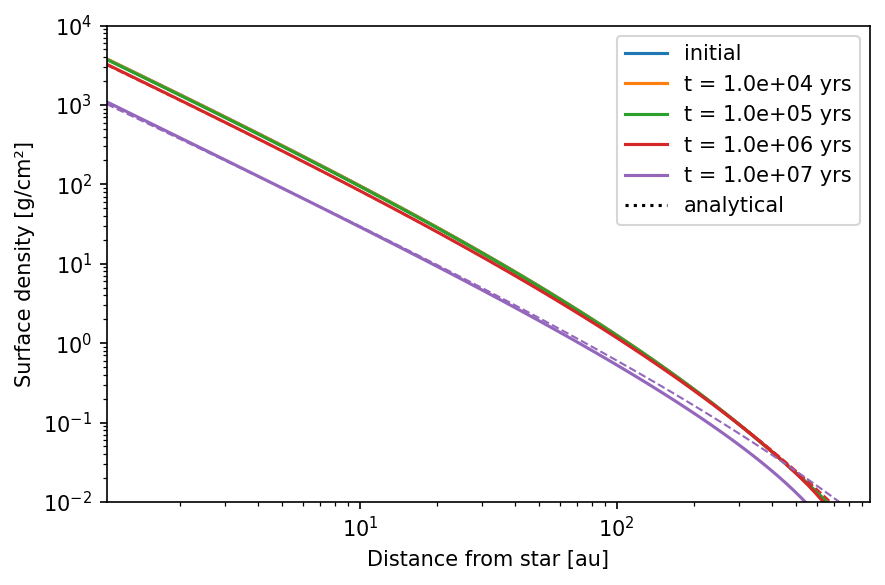

In [43]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.loglog(data.grid.r[0]/c.au, data.gas.Sigma[0], c="C0", label="initial")
for i in range(1, len(sim.t.snapshots)+1):
    cstr = "C"+str(i)
    ax.loglog(sim.grid.r/c.au, LBP74_analytical(sim.grid.r, sim.ini.gas.SigmaRc, data.gas.nu[0], sim.ini.gas.Mdisk, data.t[i]), "--", lw=1, c=cstr)
    ax.loglog(data.grid.r[i]/c.au, data.gas.Sigma[i], c=cstr, label="t = {:3.1e} yrs".format(data.t[i]/c.year))
ax.plot(0., 0., ":", c="black", label="analytical")
ax.legend()
ax.set_xlim(sim.grid.r[0]/c.au, sim.grid.r[-1]/c.au)
ax.set_ylim(1.e-2, 1.e4)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel("Surface density [g/cm²]")
fig.tight_layout()

This is not perfect, but as good as it can get. The deviation at the outer boundary is due to the fact that the outer boundary conditions is setting the gas to its floor value to prevent inflow.

In general: Always test your models against analytical solutions, if possible and decide then if the errors are acceptable for you.

#### Why is the inner boundary condition not constant power law by default?

The reason for that is that a constant power law is not necessarily possible within a linear system. A power of $-1.5$ for example is not.

`DustPy` is "*cheating*" here a bit. A boundary condition of `const_pow` is behind the scenes actually a boundary condition of `val`, where the value is calculated from the current surface density. This is close enough to the actual value in most cases. After the integration the boundary condition is then strictly enforced, by setting the correct power with the new values of the surface density.

Since the default model uses a power of $-1$ and since this can be done exactly with the `const_grad` boundary condition, we prefer it over the `const_pow` condition in the default setup.